<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials/blob/main/Tutorial11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# PILImage

dataset has PILImage images of range [0,1]
we transform them to Tensor of normalized range [-1,1]

* CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False, download=False,
                                          transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
classes = ('plane', 'car','bird','cat','deer','dog','frog','horse','ship','truck')

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

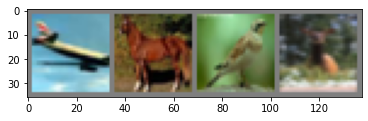

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# model

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x))) #-> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) #-> n, 16, 5, 5
        x = x.view(-1, 16*5*5) #-> n, 400
        x = F.relu(self.fc1(x)) #-> n, 120
        x = F.relu(self.fc2(x)) #-> n, 84
        x = self.fc3(x) #-> n, 10
        return(x)

model = ConvNet().to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## learning

In [24]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shapes: [4,3,32,32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/5], Step [2000/12500], Loss: 2.2999
Epoch [1/5], Step [4000/12500], Loss: 2.2905
Epoch [1/5], Step [6000/12500], Loss: 2.3269
Epoch [1/5], Step [8000/12500], Loss: 2.2097
Epoch [1/5], Step [10000/12500], Loss: 2.0456
Epoch [1/5], Step [12000/12500], Loss: 2.0062
Epoch [2/5], Step [2000/12500], Loss: 1.8796
Epoch [2/5], Step [4000/12500], Loss: 2.1247
Epoch [2/5], Step [6000/12500], Loss: 1.8847
Epoch [2/5], Step [8000/12500], Loss: 1.4414
Epoch [2/5], Step [10000/12500], Loss: 1.8001
Epoch [2/5], Step [12000/12500], Loss: 1.6098
Epoch [3/5], Step [2000/12500], Loss: 1.6451
Epoch [3/5], Step [4000/12500], Loss: 1.5303
Epoch [3/5], Step [6000/12500], Loss: 1.3738
Epoch [3/5], Step [8000/12500], Loss: 1.5397
Epoch [3/5], Step [10000/12500], Loss: 1.0730
Epoch [3/5], Step [12000/12500], Loss: 1.3532
Epoch [4/5], Step [2000/12500], Loss: 1.5085
Epoch [4/5], Step [4000/12500], Loss: 1.3424
Epoch [4/5], Step [6000/12500], Loss: 2.0396
Epoch [4/5], Step [8000/12500], Loss: 1.1254
Epoc

In [25]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# проверка качества модели

In [26]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.28 %
Accuracy of plane: 52.1 %
Accuracy of car: 72.1 %
Accuracy of bird: 31.1 %
Accuracy of cat: 27.0 %
Accuracy of deer: 26.2 %
Accuracy of dog: 26.3 %
Accuracy of frog: 63.5 %
Accuracy of horse: 70.1 %
Accuracy of ship: 67.4 %
Accuracy of truck: 47.0 %
